# Applied Time Series Analysis Lab 1: The ENSO Cycle and People Affected by Disasters
### John Hennin, 2021-03-03

#### **Required Packages**
* tswge (Woodward, 2016)

## Introduction

The lab is practice for uploading data into R data frames and performing some preliminary time series analyses. We are also replicating the results demonstrated in the paper. Additionally, we are tasked to search for data that may share similar trends to the data in the paper.

The central paper of the lab is *Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle* by Dr. Holly Lam, Dr. Andy Haines, Dr. Glenn McGregor, Dr. Emily Chan, and Dr. Shakoor Hajat. The main goal of this work was to look at the relationship between ENSO and the amount of people who are affected by natural disasters on global, national, and regional levels using time series analysis. They analysed PAD (people affected by natural disasters) rates with respect with ONI and MEI data (as this data is representative of ENSO activity). "PAD rates were calculated by dividing the number of people affected by the population size in the calendar year (and expressed as a rate per 1000)" (Lam et al., 2019). Further, "for the regression analysis, the combination of Poisson Generalized Additive Models (GAMs) and distributed-lag non-linear models for time-series data were used to flexibly model nonlinear and lag effects" (Lam et al., 2019). The researchers concluded that ENSO does at least partially influence health burdens with regard to climate-related disasters (Lam et al., 2019). 

The lab goal is to recalculate these PAD rates, recreate certain time series plots, and identify patterns within the ENSO.

## Methods

#### Installing Required Packages

In [1]:
install.packages("tswge")
library("tswge")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#### Getting the Data Used in the Paper
***Put PAD data in local directory***

**People Affected by Disasters** (PAD): https://public.emdat.be/data (account required) (EM-DAT, 2021)

Make the specifications listed below and click "DOWNLOAD"
* Years: 1964-2017
* Location: All
* Disaster Classification: **Natural** (Meteorological, Hydrological, Climatological, and Biological; NOT Geophysical or Extra-terrestrial)

**Multivariate El Niño Index** (MEI): https://psl.noaa.gov/enso/mei.old/table.html (PSL, 2021)

**Oceanic Niño Index** (ONI): https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt (NOAA, 2021)

**Yearly Country Populations**: http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv (World Bank, 2019)


#### Loading the PAD Data into R Data Frame (With Correct Formatting)

In [2]:
# Install Excel to R data frame package "xlsx"

install.packages("xlsx")
library("xlsx")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
# Load PAD data to R data frame
pad.filepath <- './emdat_public_2021_02_25_query_uid-v2BfI4.xlsx'

pad.df <- read.xlsx(pad.filepath, 1)

In [4]:
# Note that the first 5 rows and column names are mistakingly data/data source information
pad.df[0:5,]

# Cut off first 5 rows
pad.df <- pad.df[6:nrow(pad.df),]

,Source.,EM.DAT..CRED...UCLouvain..Brussels..Belgium,c......................Seq....9044....0024....0039....0005...,c......................Disaster.Group....Natural....Natural...,c......................Disaster.Subgroup....Climatological...,NA.,NA..1,NA..2,NA..3,NA..4,⋯,NA..28,NA..29,NA..30,NA..31,NA..32,NA..33,NA..34,NA..35,NA..36,NA..37
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,www.emdat.be (D. Guha-Sapir),,,,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Version:,2021-02-25,,,,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,File creation:,"Thu, 25 Feb 2021 20:12:38 CET",,,,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Table type:,Custom request,,,,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,# of records:,12239,,,,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [5]:
# Strip actual column names from row 6 values
col.names <- unlist(pad.df[1,])
col.names <- unname(col.names)

In [6]:
# Set column names
colnames(pad.df) <- col.names

# Reset index
row.names(pad.df) <- NULL

# Remove row with column names as values
pad.df <- pad.df[-c(1),]

# Reset index once more
row.names(pad.df) <- NULL

In [7]:
# Filter out unneccesary information
pad.df <- pad.df[c("Country", "ISO", "Start Year", "Start Month", "End Year", "End Month", "Total Affected")]

#### Loading Population Totals (For PAD Rates) (Davis, 2021a)

In [8]:
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep="")
download.file(wbank.url, wbank.file)
unzip(zipfile = wbank.file, exdir = "/tmp")

In [9]:
pop.file <- ""
for (file in list.files("/tmp")){
  g <- grep("^API_SP.POP.TOTL.*csv", file)
  if (length(g) > 0) {
    pop.file <- file
  }
}

In [10]:
pop.file <- paste("/tmp/", pop.file, sep="")

In [11]:
pop.df <- read.csv(pop.file, header = TRUE, skip = 4)

#### Adding Population Counts to PAD Data Frame (Davis, 2021a)

In [12]:
for (i in 1:nrow(pad.df)) {
  tmp.iso <- pad.df[i, ][['ISO']]
  tmp.year <- pad.df[i, ][['Start Year']]
  tmp.col <- paste("X", tmp.year, sep="")
  a <- match(tmp.iso, pop.df$Country.Code)
  if (!is.na(a)) {
    tmp.pop <- pop.df[,tmp.col][a]
    pad.df[i, 'POP'] = tmp.pop
    #print(c(tmp.iso, tmp.year, tmp.pop))
  } else {
    pad.df[i, 'POP'] = NA
    #print(paste("Could not match", tmp.iso))
  }
}

In [13]:
for (i in c(1964:2017)) {
  tmp.pad <- pad.df[pad.df["Start Year"] == i,]

  # Omitting NA values in calculations (doesn't achieve similar PAD Rates)
  #tmp.pad['Total Affected'] = as.numeric(tmp.pad$'Total Affected')
  #tmp.pad['POP'] = as.numeric(tmp.pad$'POP')
  #tmp.pad = na.omit(tmp.pad)

  # Sum total affected over sum of unique pop
  tmp.padr <- sum(as.numeric(tmp.pad$'Total Affected'), na.rm=TRUE)/sum(unique(tmp.pad$POP), na.rm=TRUE)*1000

  # Sum all PAD Rates for that year (doesn't achieve remotely the same PAD Rates)
  #r = 1
  #vals <-c()
  #while (r <= nrow(tmp.pad)){
    #tmp.padr <- (tmp.pad$'Total Affected'[r])/(tmp.pad$POP[r])
    #vals = append(vals, tmp.padr)
    #r = r+1
  #}
  #tmp.padr = sum(vals)
  if (i == 1964){
    # Create empty data frame for PAD Rate
    padr.df <- data.frame(i, tmp.padr)
    names(padr.df)<-c("Year", "PAD Rate")
  }
  else{
    tmp.df <- data.frame(i, tmp.padr)
    names(tmp.df)<-c("Year", "PAD Rate")
    padr.df <- rbind(padr.df, tmp.df)
  }
}
# References: (Becker, 1988), (Parfait, 2015)

#### Processing the PAD Rate Data Into a Time Series

In [14]:
padr.ts <- ts(as.vector(t(padr.df[,2])), start = c(1964, 1), end = c(2017))

#### Loading the MEI Data Into R Data Frame (With Correct Formatting) (Davis, 2021a) (PSL, 2021)

In [15]:
# Pull MEI data from url
mei.url <- "https://psl.noaa.gov/enso/mei.old/table.html"
mei.name <- tail(unlist(strsplit(mei.url, "/")), n=1)
mei.file <- paste("/tmp/", mei.name, sep="")
download.file(mei.url, mei.file, method = 'auto')

In [16]:
# Get column names
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^YEAR.*", my.line)
  if (length(a) > 0) {
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}

In [17]:
# Create an empty dataframe
n.cols <- length(my.cols)
mei.df <- data.frame(matrix(ncol = n.cols, nrow = 0))
colnames(mei.df) <- my.cols 
str(mei.df)

'data.frame':	0 obs. of  13 variables:
 $ YEAR  : logi 
 $ DECJAN: logi 
 $ JANFEB: logi 
 $ FEBMAR: logi 
 $ MARAPR: logi 
 $ APRMAY: logi 
 $ MAYJUN: logi 
 $ JUNJUL: logi 
 $ JULAUG: logi 
 $ AUGSEP: logi 
 $ SEPOCT: logi 
 $ OCTNOV: logi 
 $ NOVDEC: logi 


In [18]:
# Get all the data lines
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^[0-9].*", my.line)
  if (length(a) > 0) {
    my.data <- unlist(strsplit(my.line, "\\s+"))
    num.data <- length(my.data)
    if (num.data == n.cols) {
      my.values <- c()
      for (d in my.data) {
        my.values <- append(my.values, as.numeric(d))
      }
      mei.df[nrow(mei.df)+1,] = my.values
    }
  }
}

#### Processing the MEI Data Into a Time Series

In [19]:
mei.ts <- ts(as.vector(t(mei.df[,2:length(my.cols)])), start = c(1950, 1), frequency = 12)

#### Loading the ONI Data Into R Data Frame (With Correct Formatting) (Davis, 2021a) (NOAA, 2021)

In [20]:
# Get ONI data from url
oni.url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni.name <- tail(unlist(strsplit(oni.url, "/")), n=1)
oni.file <- paste("/tmp/", oni.name, sep="")
download.file(oni.url, oni.file, method = 'auto')

In [21]:
# Read into df
oni.df <- read.table(oni.file, header = TRUE)

#### Processing the ONI Data Into a Time Series

In [22]:
oni.ts <- ts(oni.df$ANOM, start = c(1950, 1), frequency = 12)

#### Identifying El Ni&ntilde;o Years and Dominant Frequency
*I will be using the ONI data to do so, as the paper states "an El Niño event occurs when the ONI is higher than 0.5 °C for at least five consecutive overlapping three-month periods during July-June."$^1$*

In [23]:
# Find years with ONI > .5
enso.df <- oni.df[(oni.df$ANOM > .5),]
enso.yrs <- c()
for (y in unique(enso.df$YR)){
    tmp.df <- enso.df[(enso.df$YR == y),]
    s = 1
    f = 1
    while (s < length(tmp.df$SEAS)){
      if (substr(tmp.df$SEAS[s], start = 2, stop = 3) == substr(tmp.df$SEAS[s+1], start = 1, stop = 2)){
        f = f + 1
        if (f == 5){
          enso.yrs <- append(enso.yrs, y)
        }
      }
      else {
        f = 1
      }
      s = s+1
    }
  }

In [24]:
# Assigning ONI > .5 value of 1 and anything else a value of 0
vals <- c()
for (i in c(1951:2019)){
  if (i %in% enso.yrs){
    vals <- append(vals, 1)
  }
  else {
    vals <- append(vals, 0)
  }
}

ensoyrs.df <- data.frame(c(1951:2019), vals)

In [25]:
# Finding maximum periodogram value and cooresponding frequency (dominant frequency)

pgrams <- period.wge(ensoyrs.df$vals, plot = FALSE)$pgram
dom.freq <- period.wge(ensoyrs.df$vals, plot = FALSE)$freq[which.max(pgrams)]
dom.freq

[1] 0.173913

#### Processing the El Niño Years Data Into a Time Series

In [26]:
ENSO <- ts(as.vector(t(ensoyrs.df$vals)), start = c(1951, 1), end = (2019))

#### SOI 3-Month Running Mean Data (Exhibits Similar ENSO Patterns) (NWS, 2021) (NOAA, n.d.)

https://www.cpc.ncep.noaa.gov/data/indices/soi.3m.txt

According to the National Centers for Environmental Information, the Southern Oscillation Index is "one measure of the large-scale fluctuations in air pressure occurring between the western and eastern tropical Pacific (i.e., the state of the Southern Oscillation) during El Niño and La Niña episodes" (NCEI, n.d.).

*Unfortunately, the data does not come properly separated, as the NA values are not separated like the regular data values. The .txt file should be downloaded locally and edited directly so that the NA value (-999.9) is space separated. Loading the file without doing so will cause an error. Additionally, rows representing years 2021 to 2030 are deleted, as they are unnecessary for this purpose.*

In [27]:
# Read SOI data into df
soi.df <- read.table('./soi.3m.txt', header = TRUE, sep = "")

In [28]:
# Set to 1964-2017 (to easily compare with the other ENSO data)
soi.df <- soi.df[14:67,]

In [29]:
# Process into time series
soi.ts <- ts(as.vector(t(soi.df[,2:length(my.cols)])), start = c(1964, 1), end = (2017), frequency = 12)

## Results

#### Recreating Fig. 1

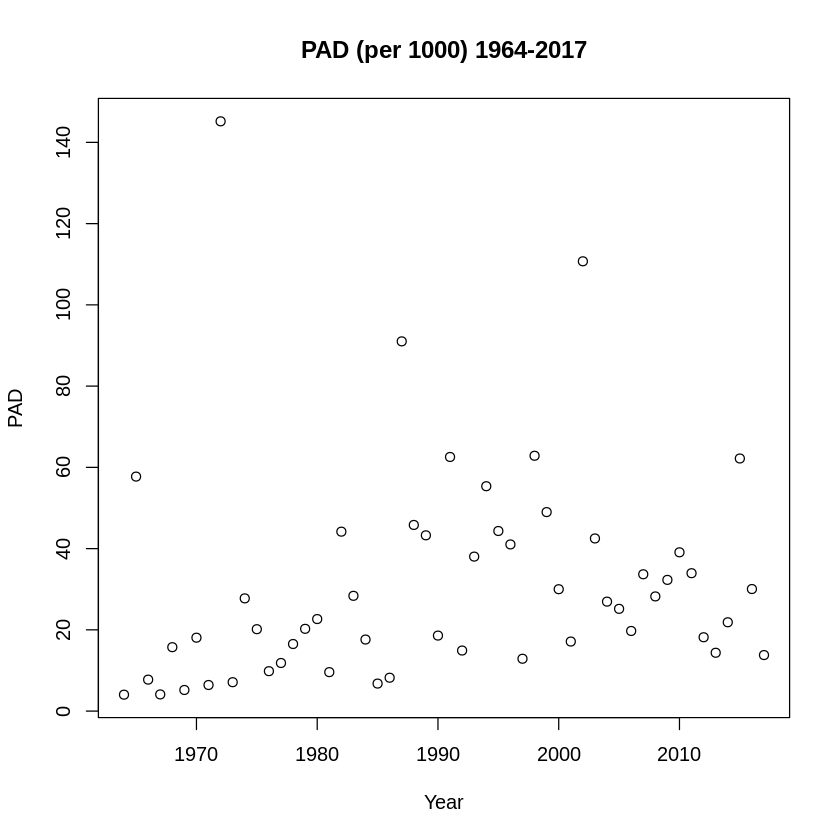

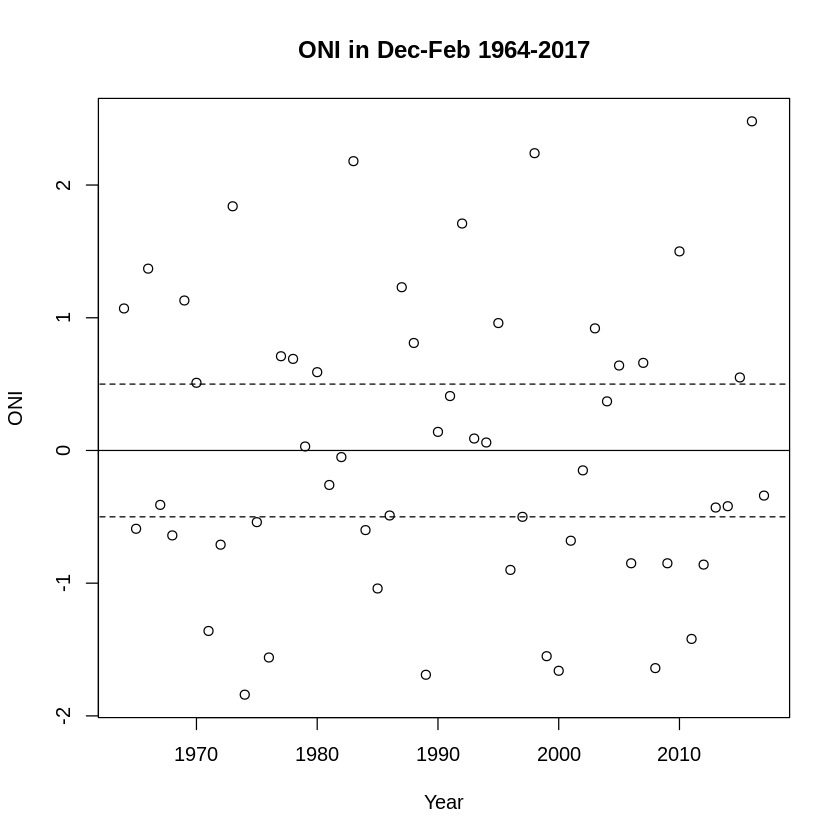

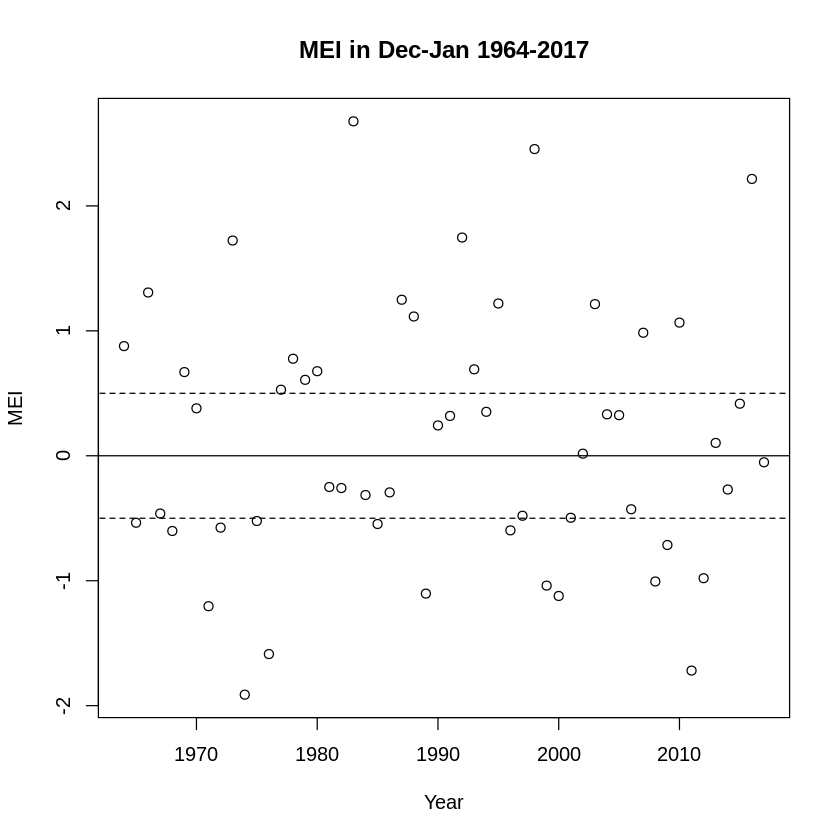

In [30]:
# PAD Rate Plot (for every year from 1964 to 2017)
plot(x = c(1964:2017), y = padr.df[,2], type = "p", xlab = "Year", ylab = "PAD", main = "PAD (per 1000) 1964-2017")

# ONI Plot (for Dec-Jan-Feb of every year from 1964 to 2017)
plot(x = c(1964:2017), y = oni.df[oni.df$SEAS == "DJF",][15:68,]$ANOM, type = "p", xlab = "Year", ylab = "ONI", main = "ONI in Dec-Feb 1964-2017")
lines(x = c(1950:2020), rep(.5, times = length(c(1950:2020))), lty = 2)
lines(x = c(1950:2020), rep(0, times = length(c(1950:2020))), lty = 1)
lines(x = c(1950:2020), rep(-.5, times = length(c(1950:2020))), lty = 2)

# MEI Plot (for Dec-Jan of every year from 1964 to 2017)
plot(x = c(1964:2017), y = mei.df[15:68,2], type = "p", xlab = "Year", ylab = "MEI", main = "MEI in Dec-Jan 1964-2017")
lines(x = c(1950:2020), rep(.5, times = length(c(1950:2020))), lty = 2)
lines(x = c(1950:2020), rep(0, times = length(c(1950:2020))), lty = 1)
lines(x = c(1950:2020), rep(-.5, times = length(c(1950:2020))), lty = 2)

*Recreation of Fig. 1 (Lam et al., 2019)*

#### Plotting and Analyzing PAD Rate Data

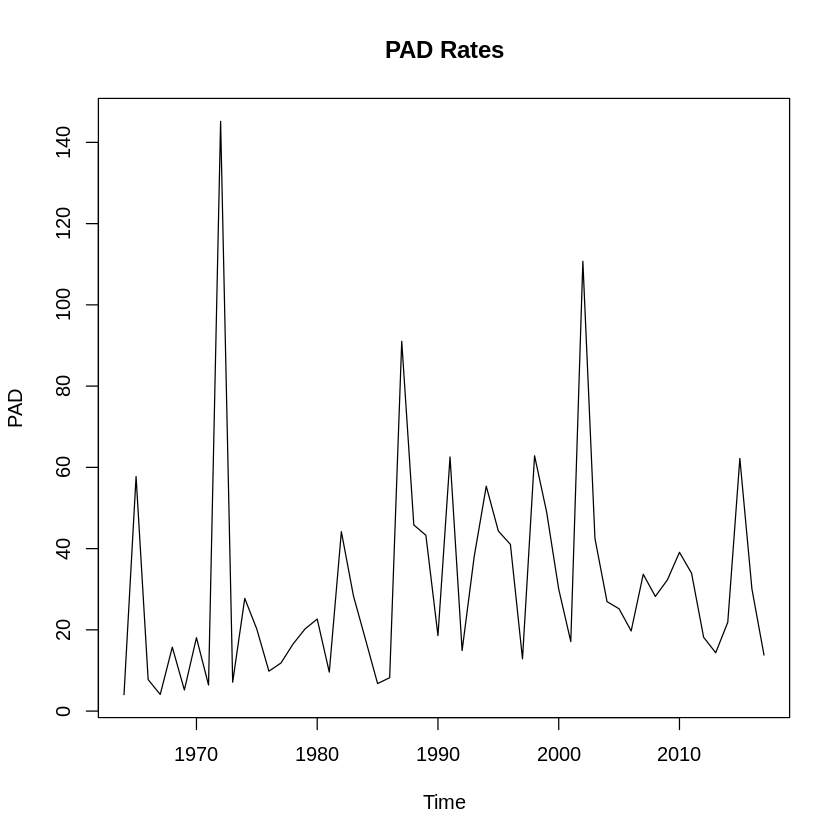

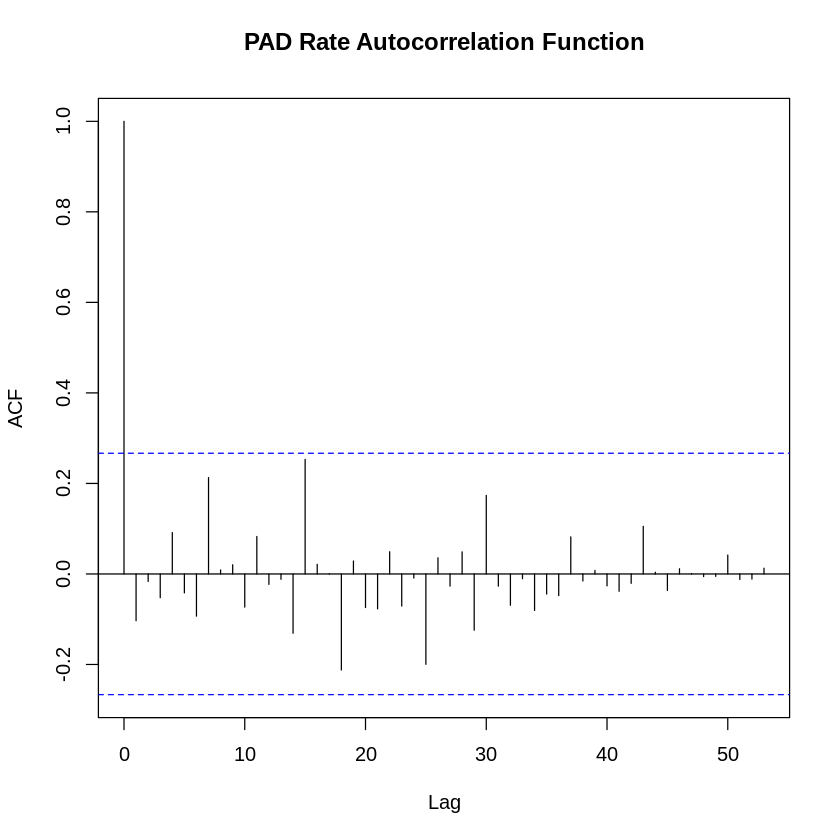

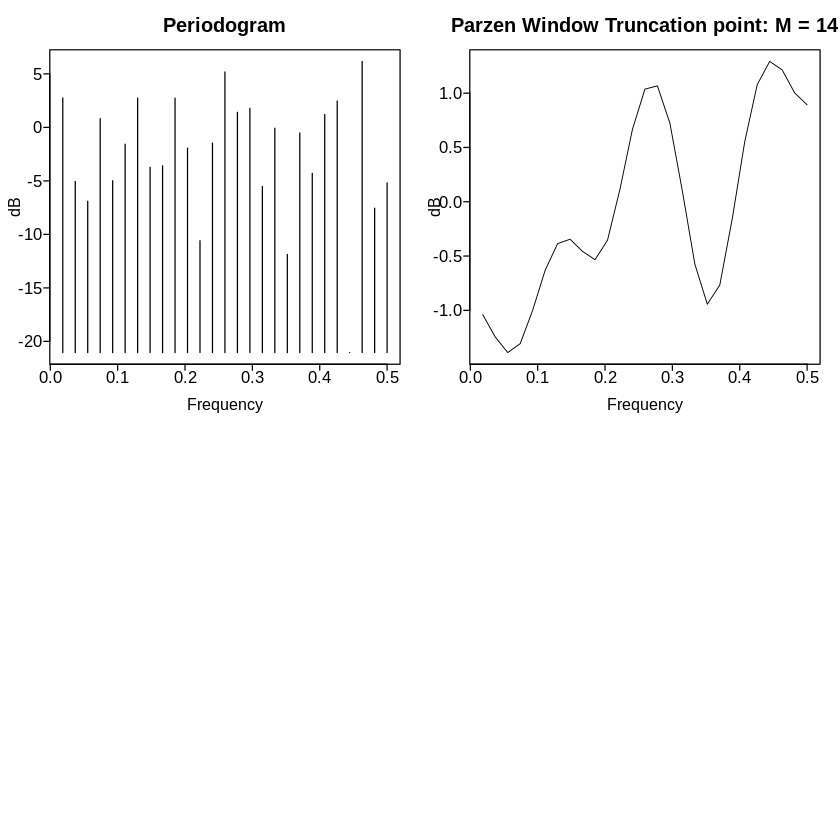

In [43]:
PAD <- padr.ts

plot(PAD, main = "PAD Rates")
acf(PAD, lag.max=100, main = "PAD Rate Autocorrelation Function")
padr.figs <- plotts.parzen.wge(PAD)

*These plots represent different information about the yearly PAD rate. From top to bottom (and then, at the bottom, left to right), the plots display the realization of the yearly PAD rate, the autocorrelations of the yearly PAD rate, the periodogram frequencies, and the Parzen window frequencies (in order to better visualize dominant frequencies).*

**PAD Rate Analysis**

Based on the Parzen Window, the dominant frequency is about .45, followed by the second dominant frequency at roughly .28 (which equate to periods of about 2.2 and 3.5 years, respectively). However, the original periodogram suggests aperiodic behavior, as there's not a very distinct dominant frequency. Additionally, the ACF shows very little autocorrelation, regardless of lag, which further suggests aperiodic behavior, or, at the very least, a lack of a strong pattern. Thus, this process seems somewhat psuedo-periodic.

#### Plotting and Analyzing ONI Data


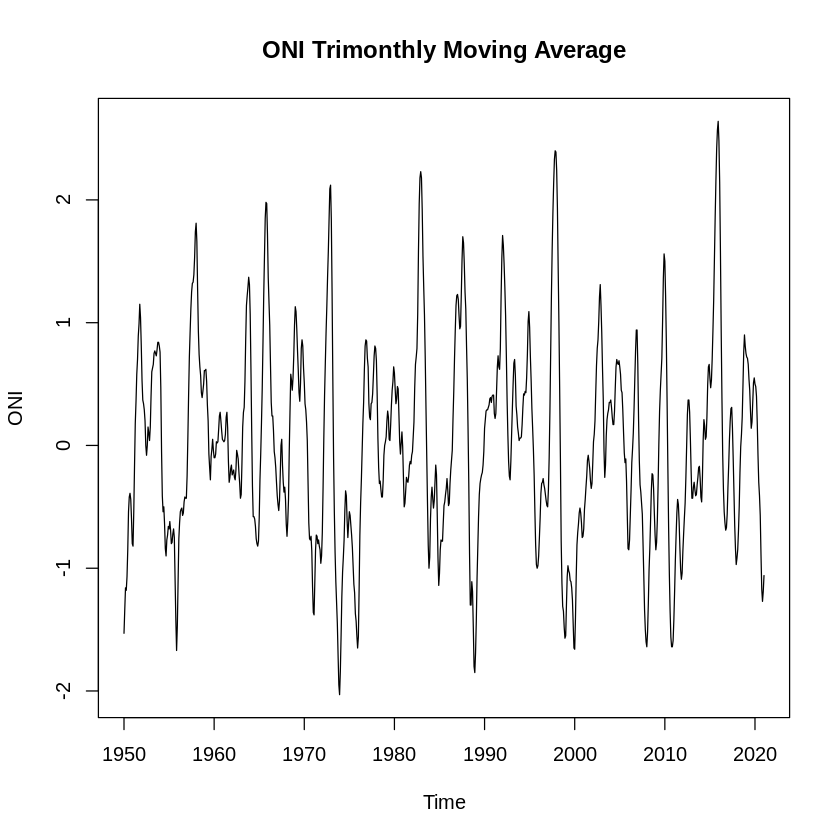

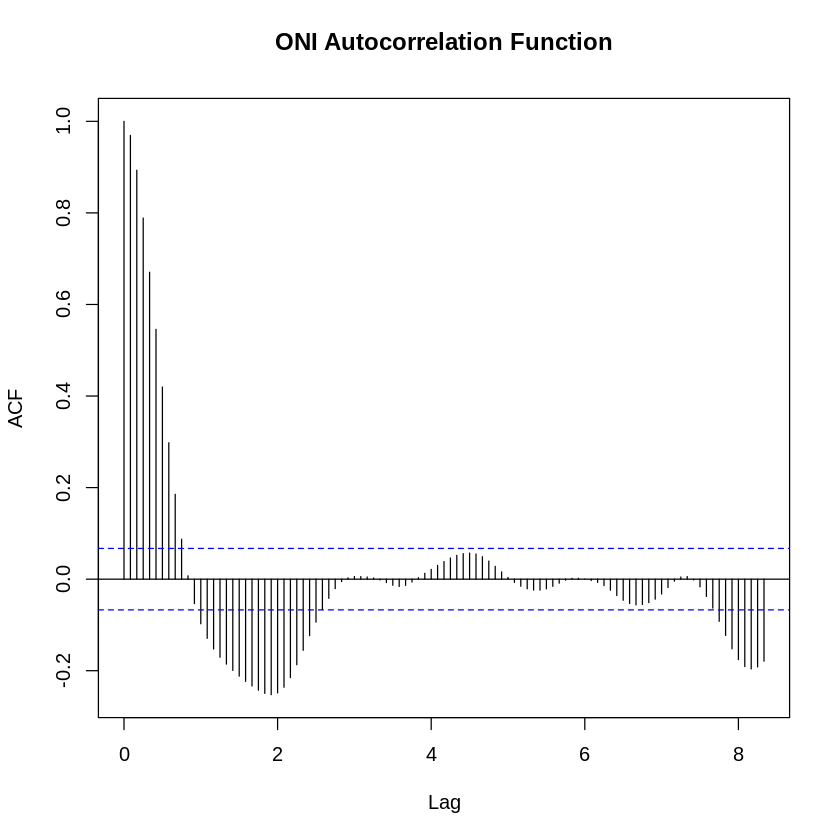

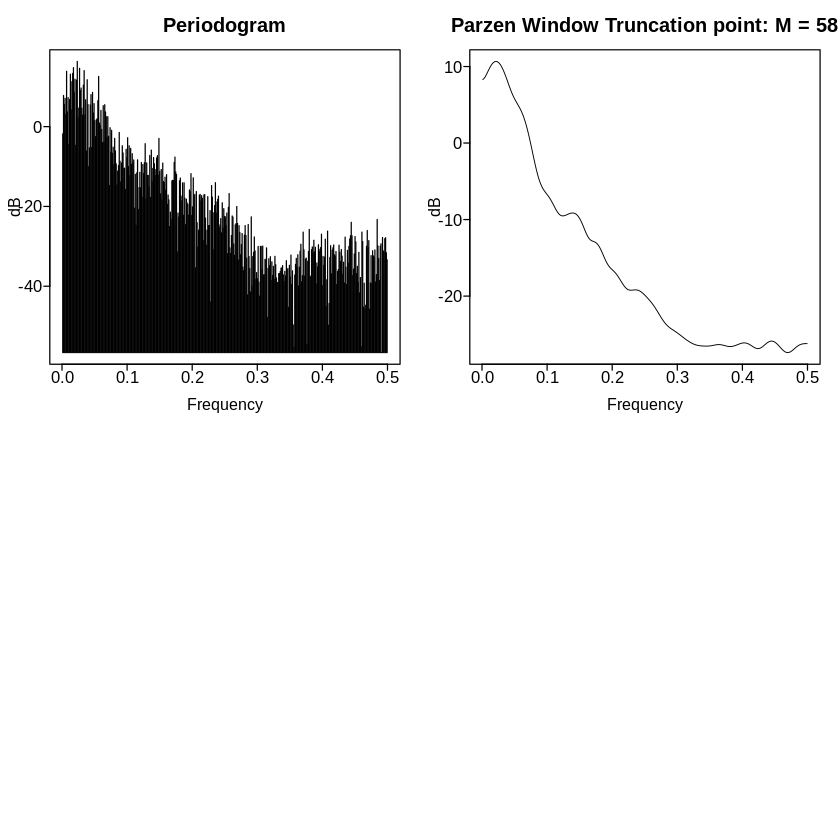

In [39]:
ONI <- oni.ts

plot(ONI, main = "ONI Trimonthly Moving Average")
acf(ONI, lag.max=100, main = "ONI Autocorrelation Function")
oni.figs <- plotts.parzen.wge(ONI)

*These plots represent different information about the ONI trimonthly moving average. From top to bottom (and then, at the bottom, left to right), the plots display the realization of the ONI trimonthly moving average, the autocorrelations of the ONI trimonthly moving average, the periodogram frequencies, and the Parzen window frequencies (in order to better visualize dominant frequencies).*

**ONI Analysis**

Given the Parzen Window, the dominant frequency is around .025, which is, notably, a very low frequency (and thus a large period of $1/.025 = 40$ months). There is also a slight peak at roughly .14, which could suggest a second dominant frequency, slightly higher than the first. This would indicate a period of $1/.14 ≈ 7$ months. Further, there seems to be a much higher, third dominant frequency in the time series plot, which could be the incredibly slight peak at about .44 in the Parzen Window (indicating a period of $1/.44 ≈ 2$ months). However, the ACF demonstrates significant autocorrelation only at early lags. Collectively, this indicates pseudo-periodic behavior.

#### Plotting and Analyzing MEI Data


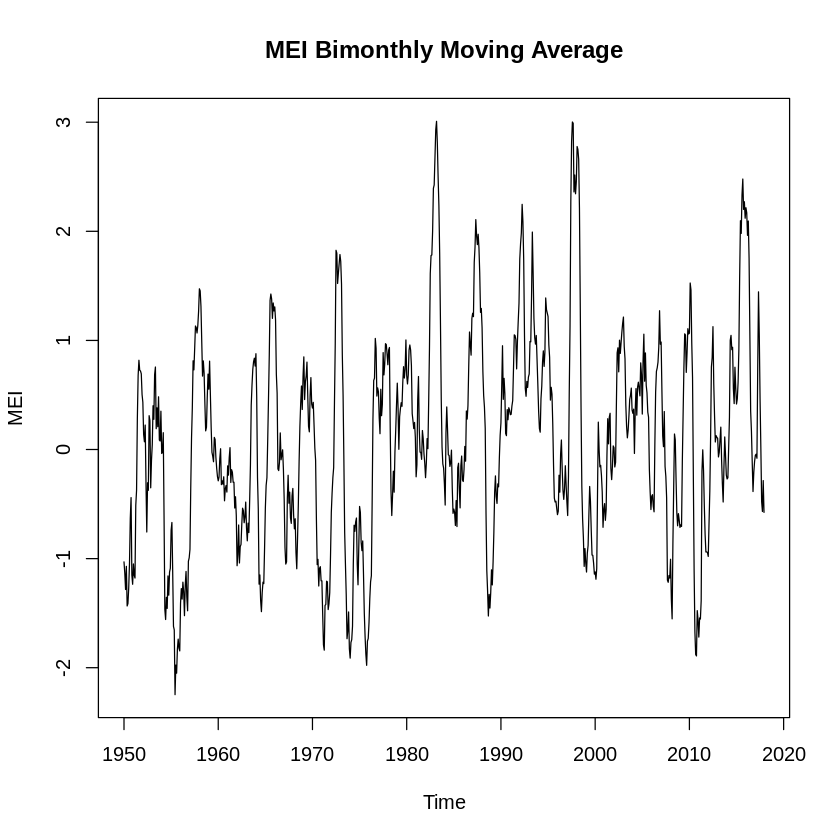

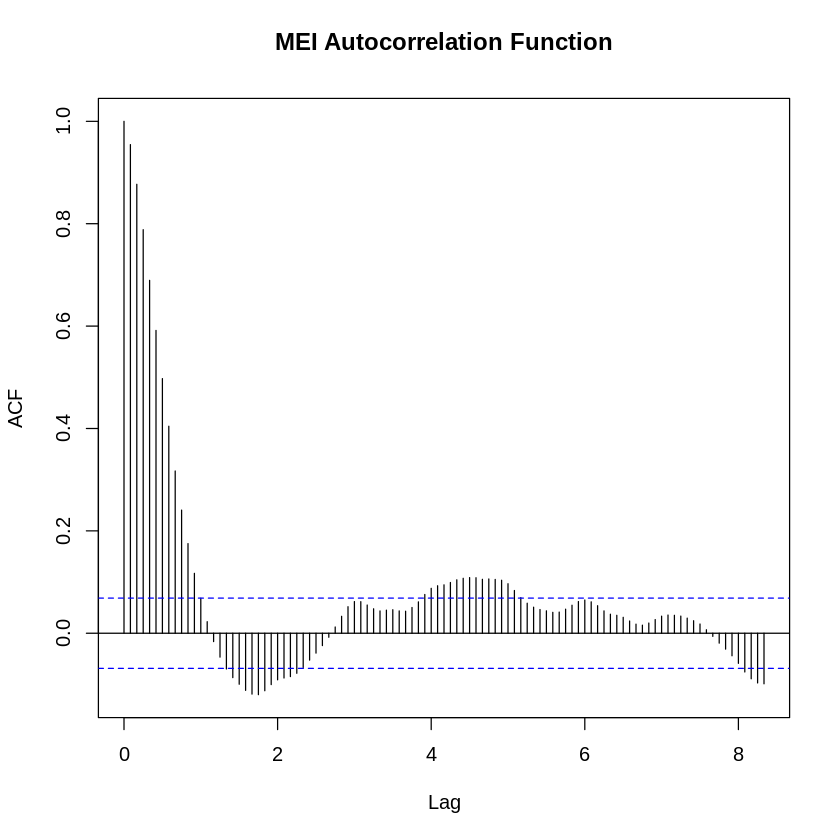

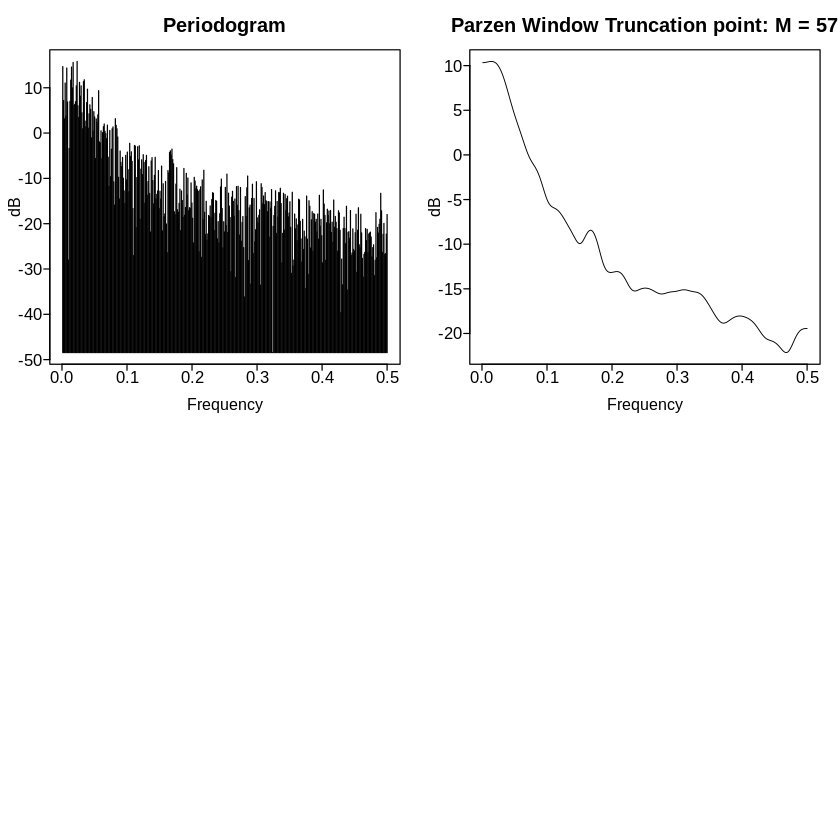

In [38]:
MEI <- mei.ts

plot(MEI, main = "MEI Bimonthly Moving Average")
acf(MEI, lag.max = 100, main = "MEI Autocorrelation Function")
mei.figs <- plotts.parzen.wge(MEI)

*These plots represent different information about the MEI bimonthly moving average. From top to bottom (and then, at the bottom, left to right), the plots display the realization of the MEI bimonthly moving average, the autocorrelations of the MEI bimonthly moving average, the periodogram frequencies, and the Parzen window frequencies (in order to better visualize dominant frequencies).*

**MEI Analysis**

The Parzen window seems to show two fairly notable dominant frequencies. The firstmost dominant is a very small frequency, at roughly .025. The second is a relatively small peak at about .16. These frequencies represent periods of ($1/.025 = 40$) $40$ and ($1/.16 = 6.25$) $6.25$ months, respectively. The ACF plot shows some strong correlation at extremely small lags, but this phenomena seems to end very quickly. Collectively, much like the very similar ONI data, this indicates pseudo-periodic behavior.

#### El Ni&ntilde;o Years and Dominant Frequency Plots

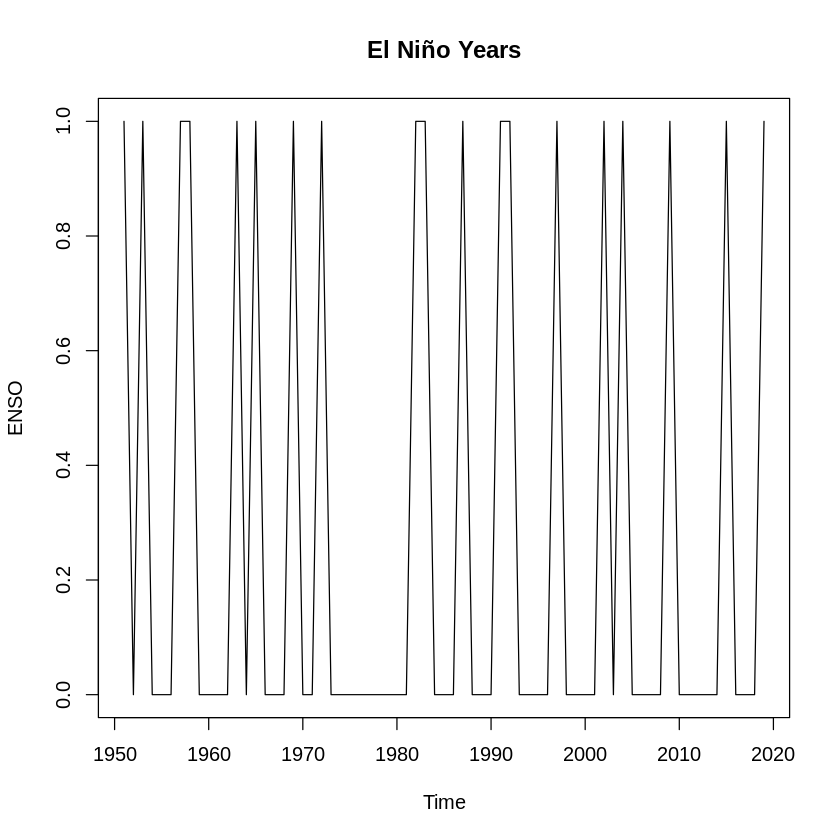

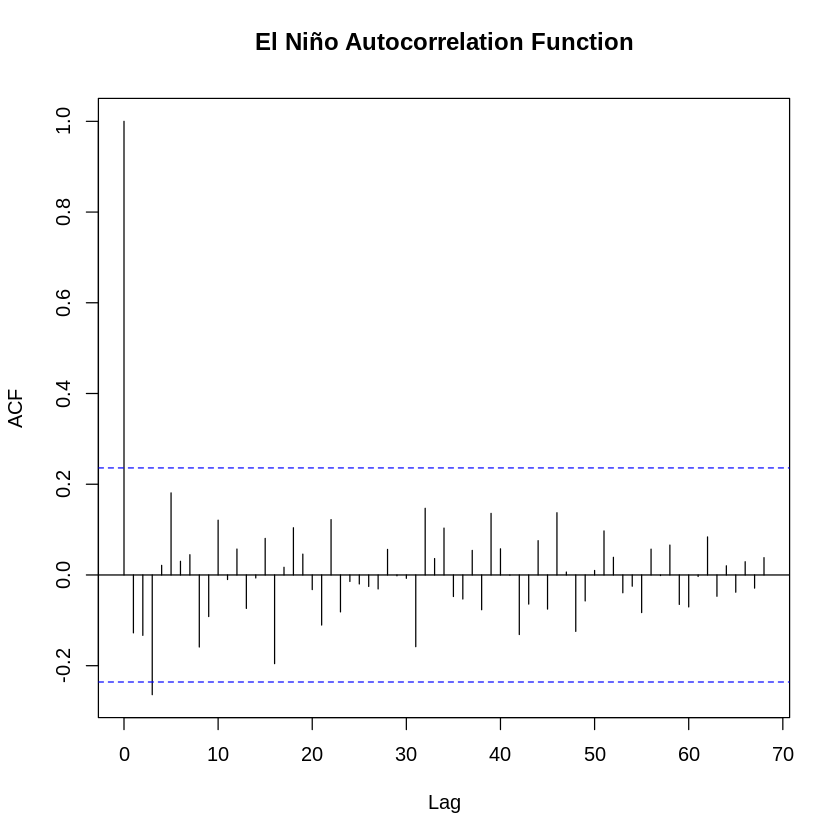

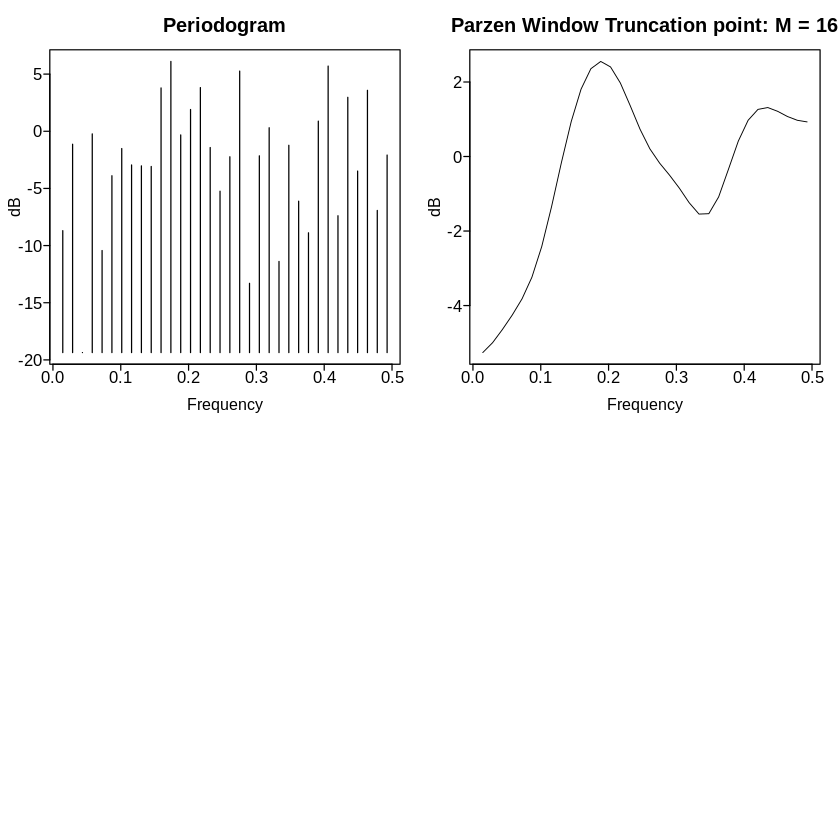

In [37]:
plot(ENSO, main = "El Niño Years")
acf(ENSO, lag.max = 100, main = "El Niño Autocorrelation Function")
enso.figs <- plotts.parzen.wge(ENSO)

*These plots represent different information about El Niño years, weighted binarily (identified El Niño year = 1, non El Niño year = 0). From top to bottom (and then, at the bottom, left to right), the plots display the realization of El Niño years, the autocorrelations of El Niño years, the periodogram frequencies, and the Parzen window frequencies (in order to better visualize dominant frequencies).*

#### Plotting and Analyzing SOI Data


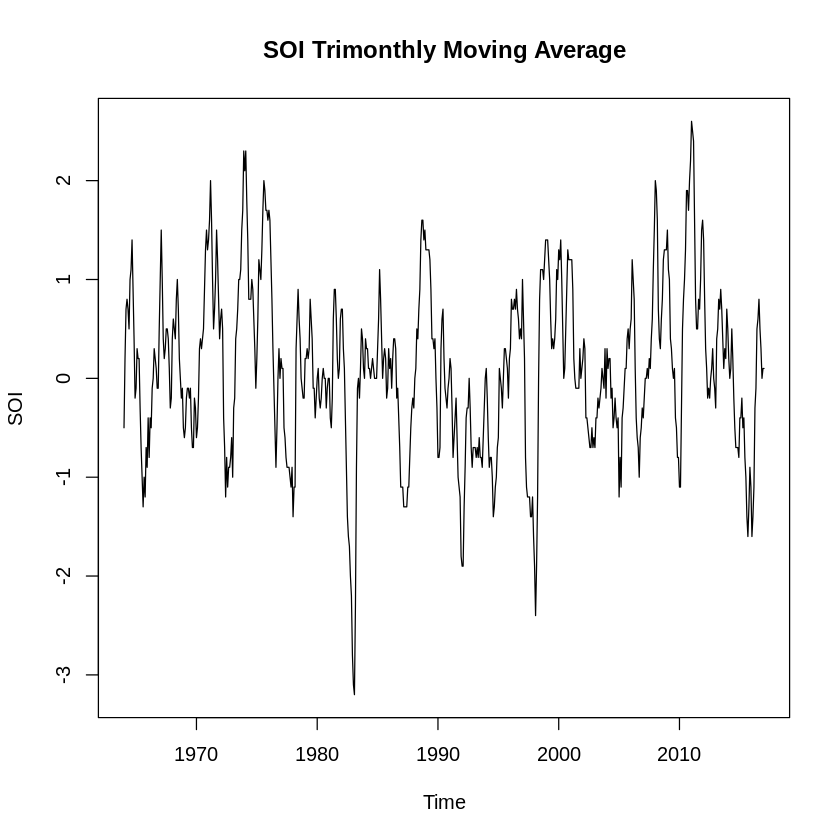

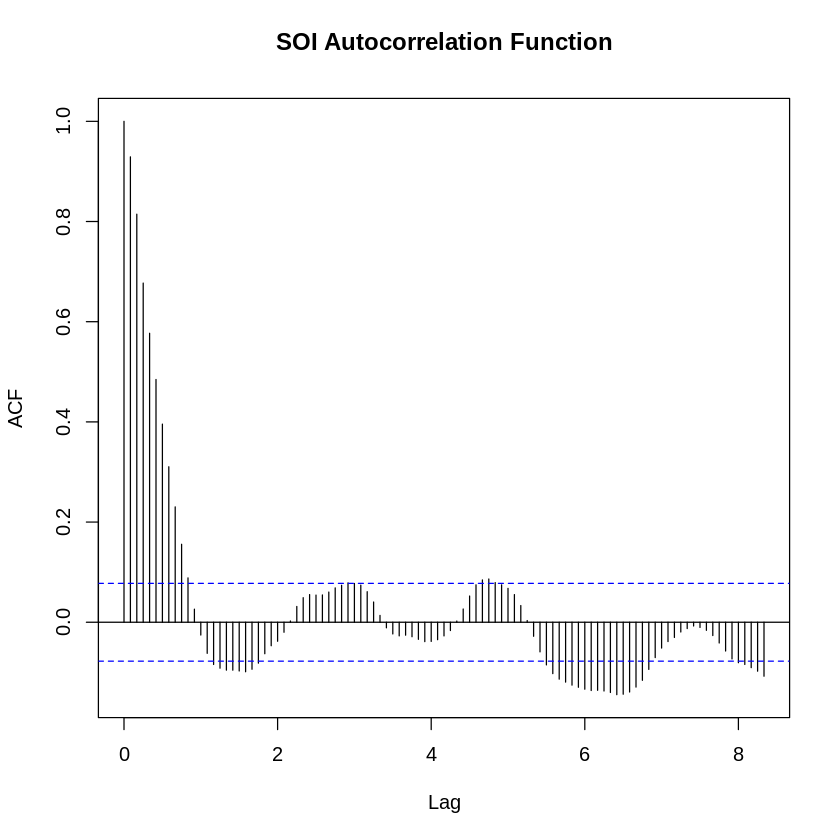

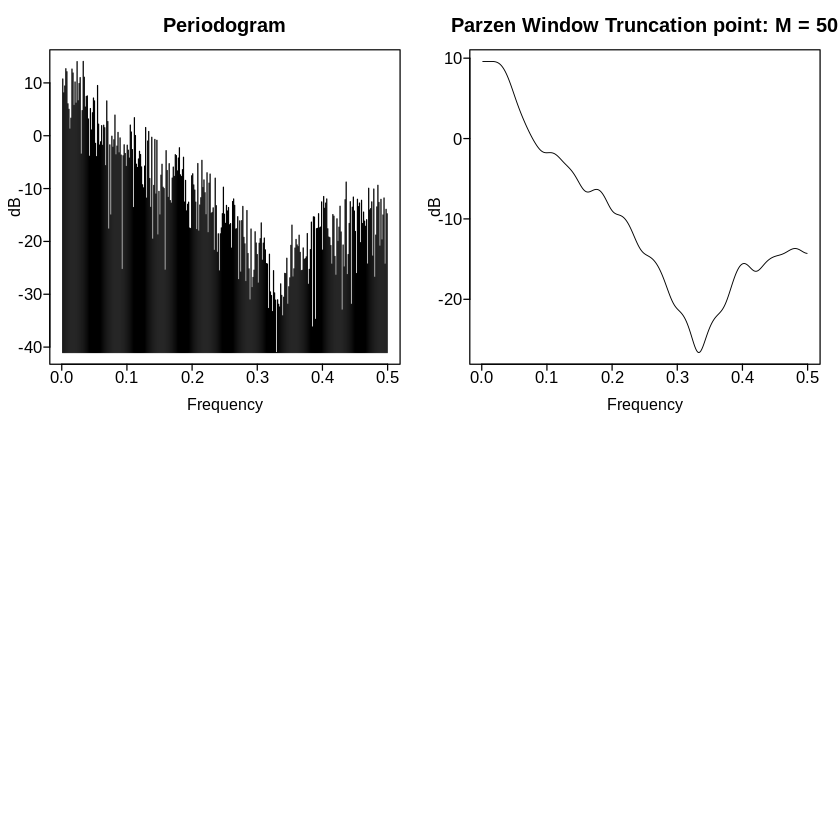

In [36]:
SOI <- soi.ts

plot(SOI, main = "SOI Trimonthly Moving Average")
acf(SOI, lag.max = 100, main = "SOI Autocorrelation Function")
soi.figs <- plotts.parzen.wge(SOI)

*These plots represent different information about the SOI trimonthly moving average. From top to bottom (and then, at the bottom, left to right), the plots display the realization of the SOI trimonthly moving average, the autocorrelations of the SOI trimonthly moving average, the periodogram frequencies, and the Parzen window frequencies (in order to better visualize dominant frequencies).*

**SOI Analysis**

Shown in the top plot are the SOI trimonthly moving averages. It seems to have a few dominant frequencies, specifically one lower frequency (with a period of roughly 2.5-5 months) and one or two higher frequencies. The periodogram and Parzen window suggest a somewhat different conclusion, as there seems to be a very low dominant frequency around .033, which would indicate a period of 30 months. Additionally, there are a few very subtle peaks around .4 and .485, which indicate periods of 2.5 and 2 months, respectively. Given the arguable peak at frequency 0, it is possible that there is either aperiodic behavior or an even longer period. We see in the autocorrelation diagram at the top right that there is some significant correlation for lower lags, but this swiftly decreases until reaching a notably low correlation range of $\pm$ .15. Collectively, the SOI data seems to behave psuedo-periodically, much like the ONI and MEI data.

## Conclusion

I loaded the PAD data from a locally downloaded Excel spreadsheet and, using World Bank population data, calculated the PAD rates per year. Then, I loaded the MEI and ONI data and processed all the data into time series'. I also found El Niño years by indexing through the ONI data and finding years where the ONI was above .5 for five consecutive three month moving averages (which is the statistic the paper used to define El Niño years). I then calculated the El Niño dominant frequencies by assigning each El Niño year to a value of 1 and each non El Niño year with a value of 0. I also loaded another El Niño index, the Southern Oscillation Index (SOI), after downloading the .txt file locally and making some preliminary adjustments. To help my analyses for PAD rate, ONI, and MEI, I plotted their realizations, their sample autocorrelation functions, and their periodograms (along with their Parzen windows for easier analysis). The acf() function plots the correlation of the time series with itself at different lags. If there is high autocorrelation at different steps of lags (such as a value of 1 at lag = 2, -1 at lag = 3, then back to 1 at lag = 4, and so on) then the time series is demonstratic periodic behavior, as there seems to be very similar or identical observational values at different steps, with the time difference of each step being somewhat regular. The periodogram is used to estimate the spectral density. Simply, the periodogram tests multiple frequencies and plots the decibel each frequency achieves with respect to the original time series.  This means that the frequency with the highest decibel value is the dominant frequency of the time series (the most similar/representative frequency to/of the time series). The Parzen window smoothes the periodogram out and thus helps visually identify the dominant frequencies. It does so by implementing a truncation point that is less than $n$, the amount of observations. According to the Block 1 notebook, "The basic problem with the periodogram is that estimations of $\gamma_j$ when $j$ is close to $n$ are extremely variable" (Davis, 2021b). The truncation point of the Parzen window prevents $j$ from getting close to $n$. Contrary to my initial belief, I found that the PAD rate, the ONI, and the MEI were all psuedo-periodic processes, with quite subtle frequencies and periods. I had difficulty replicating the PAD rates from the paper, and, although I got close, I still wasn't able to achieve exactly the same results. I first tried summing all the PAD rates for each year, but those PAD rates were far too high. Additionally, I found that removing all the NA values from the PAD data actually worsened the inaccuracy. So, I decided to keep it the way I had it originally; all PAD for a year were added together and divided by the sum of the populations affected (each nation's population was counted only once for the year).

## References

1. Becker, R. A., Chambers, J. M., & Wilks, A. R. (1988). The New S Language : A Programming Environment for Data Analysis and Graphics (Ser. Wadsworth & brooks/cole computer science series). Wadsworth & Brooks/Cole Advanced Books & Software.
1. Davis, T. (2021, March 2). Applied Time Series Analysis—Code Snippet. https://colab.research.google.com/drive/1LQYV32w2alxA8AMwlJC2PHjAyfs58I5M?usp=sharing
1. Davis, T. (2021, February 23). Applied Time Series Analysis: Course Notebook—Student Copy. https://colab.research.google.com/drive/16vRnZEVY3we9jXIJotyDzVYjXH_gt8VX?usp=sharing#scrollTo=O390nv8wwxw7
1. EM-DAT, CRED. (n.d.). EM-DAT Query Tool. UCLouvain, Brussels, Belgium (D. Guha-Sapir). https://public.emdat.be/
1. Lam, H. C. Y., Haines, A., McGregor, G., Chan, E. Y. Y., & Hajat, S. (2019). Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle. International Journal of Environmental Research and Public Health, 16(17), 3146. MDPI AG. Retrieved from http://dx.doi.org/10.3390/ijerph16173146
1. National Weather Service. (n.d.). Climate Prediction Center—Monitoring & Data: Current Monthly Atmospheric and Sea Surface Temperatures Index Values. Retrieved March 6, 2021, from https://www.cpc.ncep.noaa.gov/data/indices/
1. Parfait. (2015). dataframe—How can a add a row to a data frame in R? Stack Overflow. https://stackoverflow.com/questions/28467068/how-can-a-add-a-row-to-a-data-frame-in-r
1. Physical Sciences Laboratory, National Oceanic and Atmospheric Administration. (2021). Multivariate ENSO Index. https://psl.noaa.gov/enso/mei/
1. Southern Oscillation Index (SOI) | Teleconnections | National Centers for Environmental Information (NCEI). (n.d.). Retrieved March 6, 2021, from https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/
1. The World Bank. (2019). Population, total | Data. https://data.worldbank.org/indicator/SP.POP.TOTL
1. Wayne Woodward (2016). tswge: Applied Time Series Analysis. R package version 1.0.0. https://CRAN.R-project.org/package=tswge